# Fragment Studio
In this notebook, we illustrate how we store the physical systems in PyBigDFT, and hwo to manipulate its individual parts.

## Basic Types
In PyBigDFT, we represent the physical system we are calculating in a three level hierarchy. First, we have atoms. Each atom has a symbol and position, but might also have any general quantity associated with it. Next we have fragments, which represent collections of atoms. Finally we have systems, which contain a collection of named fragments.

### Atoms

In [1]:
from BigDFT.Atom import Atom

In [2]:
at1 = Atom(r=[0.0, 0.0, 1.0], sym="He")
at2 = Atom(r=[0.52917721092, 0.0, 0.0], sym="Ne", units="angstroem")

The most important elements of the Atom can be accessed through helper routines

In [3]:
print(at1.sym, at2.sym)
print(at1.get_position(), at2.get_position())
print(at1.get_position(units="angstroem"), at2.get_position(units="angstroem"))

He Ne
[0.0, 0.0, 1.0] [1.0, 0.0, 0.0]
[0.0, 0.0, 0.52917721092] [0.52917721092, 0.0, 0.0]


Notice how the default position value is given in bohr. Atoms behave like python dictionaries, allowing you to supplement them with any general property.

In [4]:
at1["source"] = "QM Calculation"
print(dict(at1))

{'source': 'QM Calculation', 'sym': 'He', 'r': [0.0, 0.0, 1.0]}


### Fragments
Fragments are built from a list of atoms. 

In [5]:
from BigDFT.Fragments import Fragment
frag1 = Fragment(atomlist=[at1, at2])

In [6]:
print(frag1.centroid)
print(frag1.ellipsoid())

[0.5 0.  0.5]
[[1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]]


We can also create a fragment from an XYZ file.

In [7]:
from BigDFT.FragmentIO import XYZReader
frag2 = Fragment(xyzfile=XYZReader("testfiles/three.xyz"))

Fragments behave as lists. This makes it easy to iterate over them.

In [8]:
frag3 = frag1[:1] + frag2[3:5]
for at in frag3:
    print(at.sym, at.get_position())

He [0.0, 0.0, 1.0]
C [21.333118220214985, 8.556679703057988, 1.780122066032072]
C [24.02597983744632, 5.975313816902113, 4.382274882866378]


In [9]:
print(frag2.centroid - frag2[:36].centroid)

[-1.7532459e-07 -8.8817842e-16  0.0000000e+00]


### System
At the highest level of the hierarchy are systems. Systems are collections of named fragments, and they behave like dictionaries.

In [10]:
from BigDFT.Fragments import System
three = System()
for i in range(0, len(frag2), 36):
    three["frag"+str(i)] = frag2[i:i+36]

In [11]:
for frag in three.values():
    print(frag.centroid)
print(three.centroid)
print(three.central_fragment)

[ 6.966843    4.82378834 12.43917457]
[30.64511125  4.82378834 12.43917457]
[18.80597739  4.82378834 12.43917457]
[18.80597721  4.82378834 12.43917457]
('frag0', <BigDFT.Fragments.Fragment object at 0x7fbe2f72a7f0>)


## Basic Manipulation
Now we turn to the basic manipulation of BigDFT systems and their constituent parts on space.

In [12]:
big = System()
bigf = Fragment(xyzfile=XYZReader("testfiles/BigCase.xyz"))
for i in range(0, len(bigf), 36):
    big["frag"+str(i)] = bigf[i:i+36]
print(len(big))
print(sum([len(x) for x in big.values()]))

188
6768


Here we will calculate the distance of each fragment from the center.

In [86]:
cxyz=big.centroid

In [87]:
import numpy as np
dist=[]
for frag in big.values():
    v=frag.centroid-cxyz
    dist.append(np.linalg.norm(v))

In [88]:
min(dist)

8.998864683335919

In [89]:
from BigDFT.Fragments import distance
DPP=[]
for f in big.values():
    DPP.append(np.array([distance(f,g) for g in big.values()]))

In [90]:
thr=18.0
NN=[]
for i,f in enumerate(big.values()):
    inn=0
    for g in DPP[i]:
        if g< thr and g !=0.0: inn+=1
    NN.append(inn)
import matplotlib.pyplot as plt

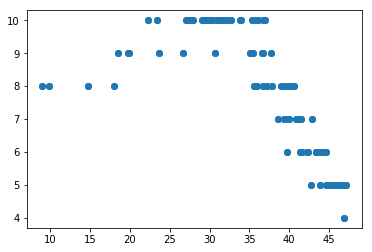

In [91]:
plotNN=plt.plot(dist,NN,'o')

In [92]:
%matplotlib inline
plt.show()

In [93]:
holef=[]
for i,n in enumerate(NN):
    if n==8 and dist[i] < 30: 
        print ('found',i,dist[i])
        holef.append(i)

found 0 14.713532748633009
found 34 17.99796827570012
found 50 8.998980617809755
found 77 9.866111346692987
found 91 14.713312006948092
found 105 17.9978894067786
found 118 8.998864683335919
found 160 9.866288996735301


In [94]:
from numpy import zeros
oxyz=zeros(3)
for h in holef:
    oxyz+= list(big.values())[h].centroid
print (oxyz/len(holef)-big.centroid)

[ 3.95779152e-05  3.96290001e-05 -3.14265335e-05]


In [95]:
frg3=list(three.values())[0]

In [96]:
c3=frg3.centroid
cb=oxyz/len(holef)
shift=np.mat(cb-c3).T

In [97]:
frg3.translate(shift)

## System Calculations
Finally, we show how to use the systems we have generated in actual calculations. First we setup the input file.

In [25]:
from BigDFT import Calculators as C
code = C.SystemCalculator(omp=2, mpi_run="mpirun")
code.update_global_options(skip=True)

Initialize a Calculator with OMP_NUM_THREADS=2 and command mpirun /home/wdawson/share/binaries/external/install/bin/bigdft


In [26]:
from BigDFT import Inputfiles as I
inp = I.Inputfile()
inp.set_xc("PBE")
inp.set_hgrid(0.4)

Build a system.

In [27]:
f1 = Fragment(xyzfile=XYZReader("testfiles/three.xyz"))[0:36]
sys = System()
sys["FRAG:1"] = f1

Now for the geometry.

In [28]:
inp["posinp"]= sys.get_posinp("angstroem")

In [29]:
log = code.run(name="test", input=inp)

Creating the yaml input file "./test.yaml"
Executing command:  mpirun /home/wdawson/share/binaries/external/install/bin/bigdft -n test -s Yes
